In [ ]:
%tensorflow_version 2.x


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install mitdeeplearning

In [ ]:
import mitdeeplearning as mdl

In [ ]:
#import other important packages
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm #to dispaly the progress


In [ ]:
!apt-get install abcmidi timidity > /dev/null 2>&1  #abcMIDI is a package of programs developed by James Allwright for processing ABC music notation files

In [ ]:
# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

Download The Dataset-   collection of thousands of Irish folklore

In [ ]:
songs = mdl.lab1.load_training_data()

Found 816 songs in text


In [ ]:
example_song = songs[0]
print("\nExample song: ")
print(example_song)

In [ ]:
# Convert the ABC notation to audio file and listen to it
mdl.lab1.play_song(example_song)

In [ ]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs) 

#Find all unique character from the joined strings
unique_vocab=list(set(songs_joined))
print("Number of unique characters from the combined songs={}".format(len(unique_vocab)))

Number of unique characters from the combined songs=83


Vectorize the text


In [ ]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.

char2idx={u:i for i,u in enumerate(unique_vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.

idx2char=np.array(unique_vocab)

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

In [ ]:
#Vectorize the song joined in he form of string
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  # for char in string:
  #   vectorized_output=np.array(char2idx[char])
  return vectorized_output

vectorized_song=vectorize_string(songs_joined)

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_song[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_song, np.ndarray), "returned result should be a numpy array"

Create Training examples and targets

In [ ]:
#batch definition and creating training examples

def get_batch(vectorized_song,seq_length,batch_size):
  n=vectorized_song.shape[0]-1  #length of vectorized songs length
  # randomly choose the starting indices for the examples in the training batch
  idx=np.random.choice(n-seq_length,batch_size)

  #List of input sequence for training batch
  
  input_batch=[vectorized_song[i:i+seq_length] for i in idx]

  # List of output sequence for training batch

  output_batch=[vectorized_song[i+1:i+seq_length+1] for i in idx]

  #Create x_batch and y_batch
  x_batch=np.reshape(input_batch,[batch_size,seq_length]) #true input for the network training
  y_batch=np.reshape(output_batch,[batch_size,seq_length]) #true target for network training
  return x_batch,y_batch

In [ ]:
x_batch, y_batch = get_batch(vectorized_song, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

In [ ]:
x_batch, y_batch = get_batch(vectorized_song, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

THE RNN MODEL BASED ON LSTM ARCHITECTURE

In [ ]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

DEFINING THE RNN MODEL

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model =tf.keras.Sequential([
  # Layer 1: Embedding layer to transform indices into dense vectors 
  #   of a fixed embedding size
  tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
  # Layer 2: LSTM with `rnn_units` number of units.
  LSTM(rnn_units),
  # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
  tf.keras.layers.Dense(vocab_size)

  ])
  return model

In [ ]:
## Building model with default hyperparameter
model = build_model(len(unique_vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

TEST THE MODEL

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           21248     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Testing the model with sequence of input of length 100
x, y = get_batch(vectorized_song, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

PREDICTIONS FROM UNTRAINED MODEL

In [ ]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

In [ ]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices]))) #predicts some non sense text

Training the model: loss and training operations

In [ ]:
## Define the loss function
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss
example_batch_loss = compute_loss(y, pred)
print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.419285


HYPER PARAMETER TUNING AND OPTIMIZATION

In [ ]:
# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1


In [ ]:
# Model parameters: 
vocab_size = len(unique_vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048


In [ ]:
# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [ ]:
#Optimisers
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [ ]:
#Train the model
def train_step(x,y):
  with tf.GradientTape() as tape:
    y_hat=model(x) #feed the input into the model to predict
    
    #compute loss:
    loss=compute_loss(y,y_hat)
  
  #compute the gradient
  grads=tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss



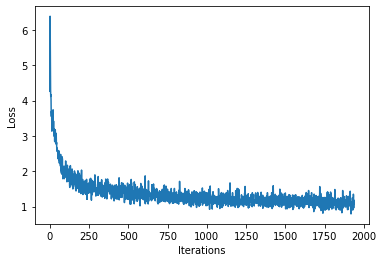

100%|██████████| 2000/2000 [01:03<00:00, 31.31it/s]


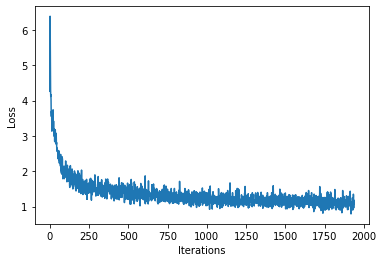

In [ ]:
##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_song, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)

In [ ]:
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

GENERATE MUSIC USING RNN MODEL

In [ ]:
# Rebuild the model with batch_size=1
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


THE PREDICTION PROCEDURE

In [ ]:
#prediction of a generated song
def generate_text(model, start_string, generation_length=1000):
  #generating musical text from learned RNN

  #vectorize the start string
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = [] #empty string to store our result
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      ''' evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      ''' use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id]) 
  return (start_string + ''.join(text_generated))




In [ ]:
#Use the model and the function defined above to generate ABC format text of length 1000!
#As you may notice, ABC files start with "X" - this may be a good start string.

generated_text = generate_text(model, start_string="X", generation_length=1500)

PLAYBACK THE GENERATED MUSIC

In [ ]:
generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)